In [111]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.special import rel_entr
import pandas  as pd
import random
import os
import tqdm
from tqdm import trange

In [2]:
import sys
sys.path.append(r"E:\Fine-Grained_Features_Alignment_via_Constrastive_Learning")
from src import PLM_embedding


In [21]:
a = PLM_embedding()
text = {
    "No Finding": "No pathological findings observed in the X-ray image; a normal result indicating the absence of detectable abnormalities or diseases.",
    "Enlarged Cardiomediastinum": "Enlargement of the heart and the structures in the central part of the chest, visible on a chest X-ray, often identified in the mediastinal region.",
    "Cardiomegaly": "Abnormal enlargement of the heart, potentially observed in the cardiac silhouette on a chest X-ray, indicating an increase in cardiac size.",
    "Lung Lesion": "An abnormality or injury in the lung tissue, which may include tumors, nodules, or other lesions, affecting specific areas within the lungs.",
    "Lung Opacity": "Increased density or lack of transparency in lung tissue observed on X-ray images, affecting various regions of the lungs and compromising visibility.",
    "Edema": "Accumulation of excess fluid in the body tissues, including the lungs, leading to swelling; in X-ray images, may manifest as increased density in the lung parenchyma.",
    "Consolidation": "Solidification of lung tissue, often due to conditions like pneumonia, affecting specific areas of the lungs and causing reduced air exchange.",
    "Pneumonia": "Inflammation of the lung tissue, typically affecting specific lobes or segments of the lungs, visible as infiltrates on X-ray images.",
    "Atelectasis": "Collapse or partial collapse of lung tissue, causing reduced air volume in specific lung regions, often observed as opacities on X-ray.",
    "Pneumothorax": "Presence of air in the pleural space, causing lung collapse; usually seen as a dark area along the pleural line on X-ray images.",
    "Pleural Effusion": "Accumulation of excess fluid in the pleural cavity, typically seen as blunting of the costophrenic angles or as fluid collections in specific pleural spaces on X-ray.",
    "Pleural Other": "Various abnormalities affecting the pleura, including pleurisy, pneumopleuritis, or pleural thickening; localized changes visible in the pleural region on X-ray.",
    "Fracture": "Break or crack in bones of the rib cage or sternum, often visible as discontinuities in specific ribs or bone structures on X-ray.",
    "Support Devices": "Presence of medical support devices in the patient, such as ventilators, tubes, or other supportive equipment; may be visible in specific areas of the chest or lung fields on X-ray."
}
print(text.items())
text_exp = [i+", "+j for i,j in text.items()]
text_exp
text_exp

dict_items([('No Finding', 'No pathological findings observed in the X-ray image; a normal result indicating the absence of detectable abnormalities or diseases.'), ('Enlarged Cardiomediastinum', 'Enlargement of the heart and the structures in the central part of the chest, visible on a chest X-ray, often identified in the mediastinal region.'), ('Cardiomegaly', 'Abnormal enlargement of the heart, potentially observed in the cardiac silhouette on a chest X-ray, indicating an increase in cardiac size.'), ('Lung Lesion', 'An abnormality or injury in the lung tissue, which may include tumors, nodules, or other lesions, affecting specific areas within the lungs.'), ('Lung Opacity', 'Increased density or lack of transparency in lung tissue observed on X-ray images, affecting various regions of the lungs and compromising visibility.'), ('Edema', 'Accumulation of excess fluid in the body tissues, including the lungs, leading to swelling; in X-ray images, may manifest as increased density in t

['No Finding, No pathological findings observed in the X-ray image; a normal result indicating the absence of detectable abnormalities or diseases.',
 'Enlarged Cardiomediastinum, Enlargement of the heart and the structures in the central part of the chest, visible on a chest X-ray, often identified in the mediastinal region.',
 'Cardiomegaly, Abnormal enlargement of the heart, potentially observed in the cardiac silhouette on a chest X-ray, indicating an increase in cardiac size.',
 'Lung Lesion, An abnormality or injury in the lung tissue, which may include tumors, nodules, or other lesions, affecting specific areas within the lungs.',
 'Lung Opacity, Increased density or lack of transparency in lung tissue observed on X-ray images, affecting various regions of the lungs and compromising visibility.',
 'Edema, Accumulation of excess fluid in the body tissues, including the lungs, leading to swelling; in X-ray images, may manifest as increased density in the lung parenchyma.',
 'Conso

In [4]:
text_exp_embeddings = a.get_biomedclip_text_embedding(text_exp)


# 加载BERT模型和tokenizer
model_name = "microsoft/BiomedVLP-CXR-BERT-specialized"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# 定义输入文本列表
text_list = text_4_clip
# 使用tokenizer对文本进行处理，确保扁平化的输入列表
inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors="pt")

# 推理模型，获取输出
with torch.no_grad():
    outputs = model(**inputs)

# 提取CLS token的输出作为句子的embedding表示
cls_embeddings = outputs.last_hidden_state[:, 0, :]


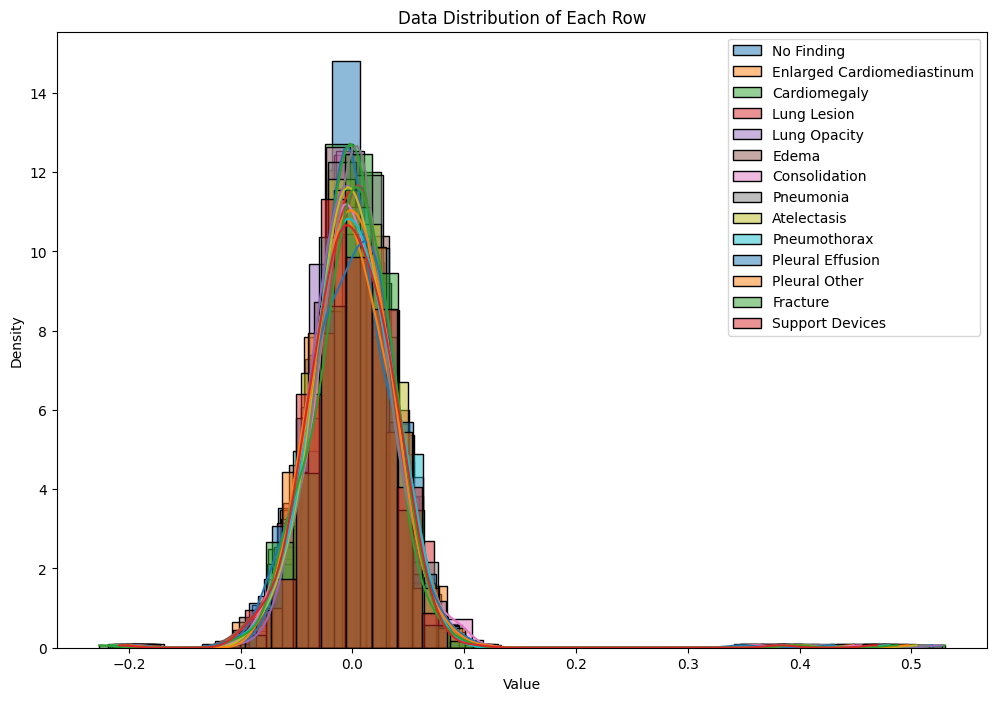

In [5]:
# 设置画布大小
tensor = text_exp_embeddings.to('cpu')
# tensor = text_features.to('cpu')
plt.figure(figsize=(12, 8))

# 绘制每一行的直方图
for i in range(tensor.size(0)):
    sns.histplot(tensor[i].numpy(), kde=True, label=f'{list(text.keys())[i]}', bins=30, stat='density')

# 显示图例
plt.legend()
plt.title('Data Distribution of Each Row')
plt.xlabel('Value')
plt.ylabel('Density')
plt.show()

---

# KL散度

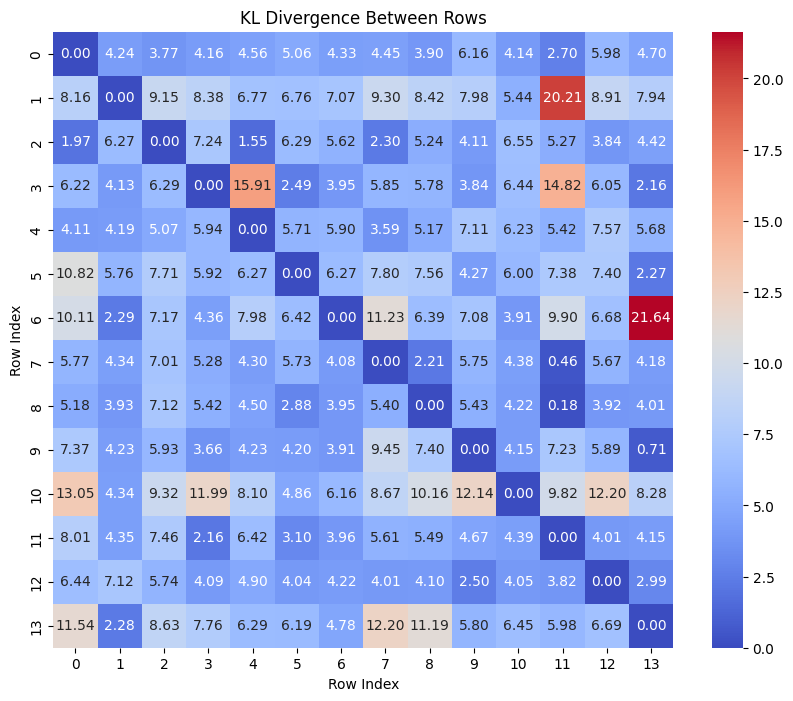

In [6]:
def calculate_kl_divergence(p, q, bins=30):
    # 计算直方图，normed=True 以使得每个bin中的总和为1
    p_hist, bin_edges = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bin_edges, density=True)
    
    # 避免零频率的问题，替换零值
    p_hist = np.where(p_hist == 0, 1e-10, p_hist)
    q_hist = np.where(q_hist == 0, 1e-10, q_hist)
    
    # 计算KL散度
    kl_div = np.sum(rel_entr(p_hist, q_hist))
    
    return kl_div

# 初始化KL散度矩阵
kl_divergence_matrix = np.zeros((tensor.size(0), tensor.size(0)))

# 计算每一行与其他行之间的KL散度
for i in range(tensor.size(0)):
    for j in range(tensor.size(0)):
        if i != j:
            kl_divergence_matrix[i, j] = calculate_kl_divergence(tensor[i].numpy(), tensor[j].numpy())

# 打印KL散度矩阵
# print("KL Divergence Matrix:")
# print(kl_divergence_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(kl_divergence_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('KL Divergence Between Rows')
plt.xlabel('Row Index')
plt.ylabel('Row Index')
plt.show()



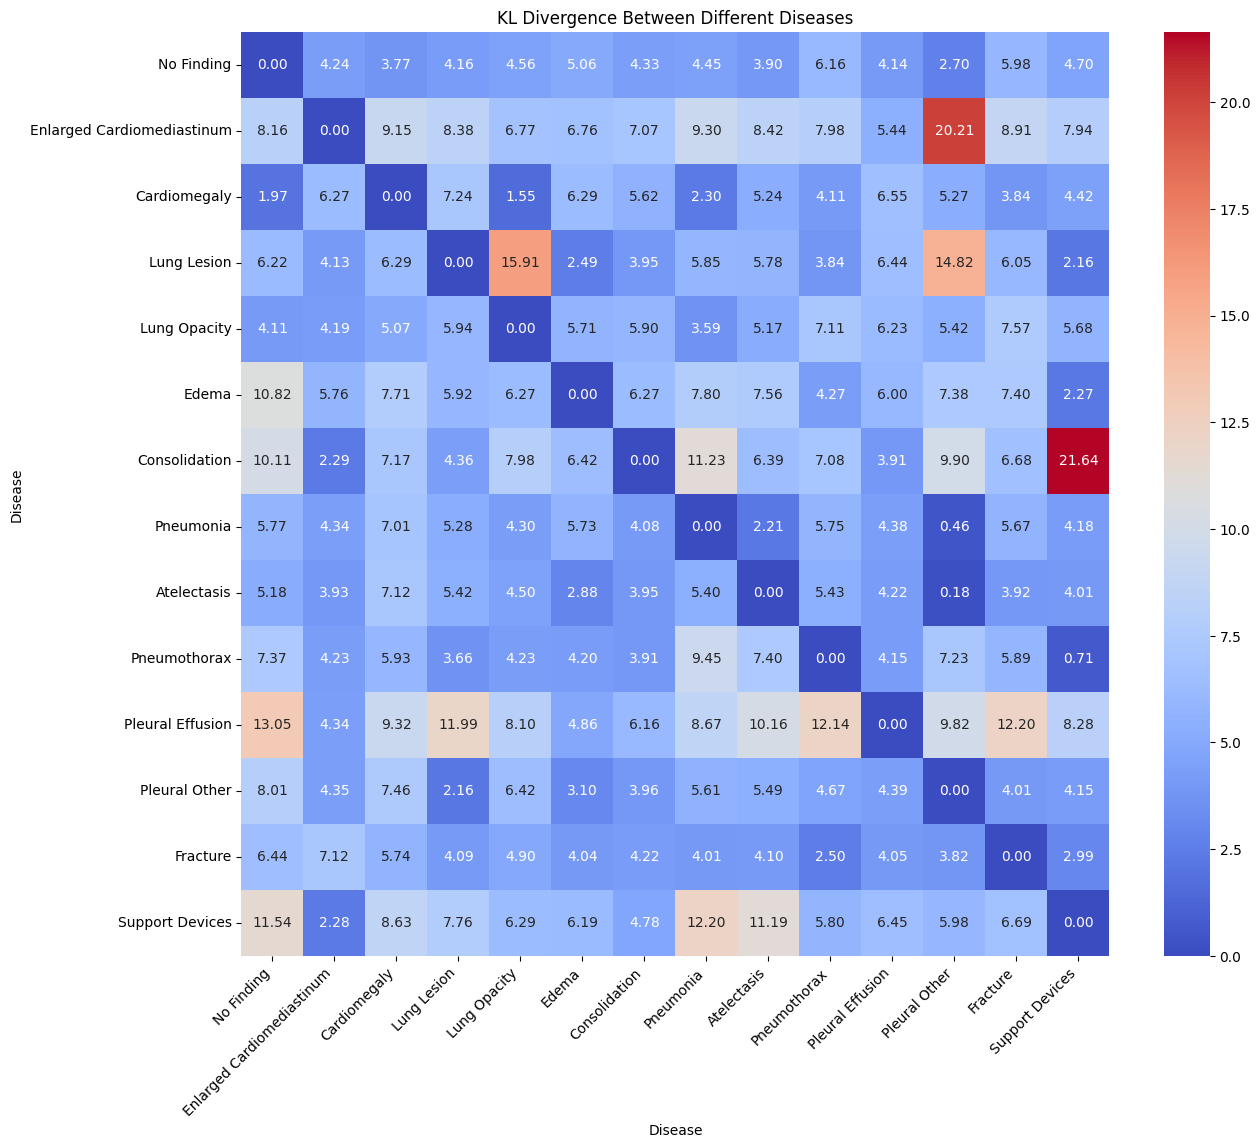

In [7]:
# 疾病名称列表
disease_names = [
    "No Finding", "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

# 文本描述
text = {
    "No Finding": "No pathological findings observed in the X-ray image; a normal result indicating the absence of detectable abnormalities or diseases.",
    "Enlarged Cardiomediastinum": "Enlargement of the heart and the structures in the central part of the chest, visible on a chest X-ray, often identified in the mediastinal region.",
    "Cardiomegaly": "Abnormal enlargement of the heart, potentially observed in the cardiac silhouette on a chest X-ray, indicating an increase in cardiac size.",
    "Lung Lesion": "An abnormality or injury in the lung tissue, which may include tumors, nodules, or other lesions, affecting specific areas within the lungs.",
    "Lung Opacity": "Increased density or lack of transparency in lung tissue observed on X-ray images, affecting various regions of the lungs and compromising visibility.",
    "Edema": "Accumulation of excess fluid in the body tissues, including the lungs, leading to swelling; in X-ray images, may manifest as increased density in the lung parenchyma.",
    "Consolidation": "Solidification of lung tissue, often due to conditions like pneumonia, affecting specific areas of the lungs and causing reduced air exchange.",
    "Pneumonia": "Inflammation of the lung tissue, typically affecting specific lobes or segments of the lungs, visible as infiltrates on X-ray images.",
    "Atelectasis": "Collapse or partial collapse of lung tissue, causing reduced air volume in specific lung regions, often observed as opacities on X-ray.",
    "Pneumothorax": "Presence of air in the pleural space, causing lung collapse; usually seen as a dark area along the pleural line on X-ray images.",
    "Pleural Effusion": "Accumulation of excess fluid in the pleural cavity, typically seen as blunting of the costophrenic angles or as fluid collections in specific pleural spaces on X-ray.",
    "Pleural Other": "Various abnormalities affecting the pleura, including pleurisy, pneumopleuritis, or pleural thickening; localized changes visible in the pleural region on X-ray.",
    "Fracture": "Break or crack in bones of the rib cage or sternum, often visible as discontinuities in specific ribs or bone structures on X-ray.",
    "Support Devices": "Presence of medical support devices in the patient, such as ventilators, tubes, or other supportive equipment; may be visible in specific areas of the chest or lung fields on X-ray."
}

# 绘制KL散度热图
plt.figure(figsize=(14, 12))
sns.heatmap(kl_divergence_matrix, annot=True, fmt=".2f", cmap='coolwarm', xticklabels=disease_names, yticklabels=disease_names)
plt.title('KL Divergence Between Different Diseases')
plt.xlabel('Disease')
plt.ylabel('Disease')
plt.xticks(rotation=45, ha='right')
plt.show()


---

# 沃森斯坦距离

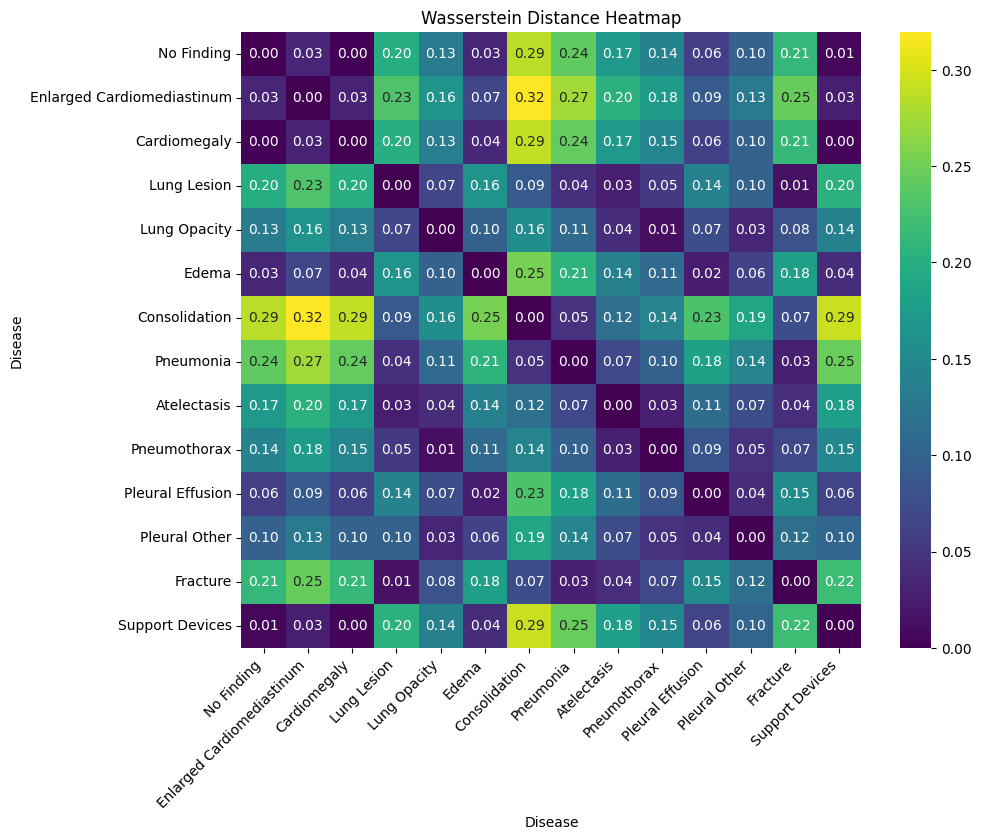

In [8]:
import numpy as np
from scipy.stats import wasserstein_distance

# 生成一个14x512的示例tensor
data = tensor.numpy()

# 计算每行的均值和方差
means = np.mean(data, axis=1)
variances = np.var(data, axis=1)

def wasserstein_distance_1d(mean1, var1, mean2, var2):
    """计算两个单变量高斯分布之间的Wasserstein距离"""
    return np.sqrt((mean1 - mean2) ** 2 + (var1 + var2 - 2 * np.sqrt(var1 * var2)))

# 计算每对向量之间的Wasserstein距离
num_vectors = data.shape[0]
distance_matrix = np.zeros((num_vectors, num_vectors))

for i in range(num_vectors):
    for j in range(i + 1, num_vectors):
        distance = wasserstein_distance_1d(
            means[i], variances[i],
            means[j], variances[j]
        )
        distance_matrix[i, j] = distance
        distance_matrix[j, i] = distance
# 使用Seaborn绘制热图
plt.figure(figsize=(10, 8))
sns.heatmap(distance_matrix*100, annot=True, fmt=".2f", cmap='viridis', 
            xticklabels=disease_names, yticklabels=disease_names)
plt.title('Wasserstein Distance Heatmap')
plt.xlabel('Disease')
plt.ylabel('Disease')
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


---

# 相似度检索

In [9]:
data_set = pd.read_csv(r"E:\Fine-Grained_Features_Alignment_via_Constrastive_Learning\data\project_dataset\CheXpert_training.csv")
data_set
CheXpert_disease_names = data_set.columns

In [10]:
CheXpert_disease_names = data_set.columns
CheXpert_disease_names = CheXpert_disease_names.drop(["Path", "Combined"]).tolist()
disease_retrieval = {}
for disease in CheXpert_disease_names:
    disease_retrieval[disease] = data_set[data_set[disease] == 1]["Path"].tolist()

for disease, num in disease_retrieval.items():
    print(f"{disease}: {len(num)} images")

Atelectasis: 53140 images
Cardiomegaly: 20475 images
Consolidation: 11484 images
Edema: 58944 images
Enlarged Cardiomediastinum: 7750 images
Fracture: 6023 images
Lung Lesion: 4918 images
Lung Opacity: 84471 images
No Finding: 11471 images
Pleural Effusion: 68816 images
Pleural Other: 1491 images
Pneumonia: 3476 images
Pneumothorax: 15891 images
Support Devices: 99028 images


In [38]:
one_images = {}
for disease, num in disease_retrieval.items():
    one_images[disease] = random.choice(num)    
one_images

{'Atelectasis': 'CheXpert-v1.0-small/train/patient50168/study6/view1_frontal.jpg',
 'Cardiomegaly': 'CheXpert-v1.0-small/train/patient62092/study1/view1_frontal.jpg',
 'Consolidation': 'CheXpert-v1.0-small/train/patient26774/study5/view1_frontal.jpg',
 'Edema': 'CheXpert-v1.0-small/train/patient02013/study11/view1_frontal.jpg',
 'Enlarged Cardiomediastinum': 'CheXpert-v1.0-small/train/patient38174/study1/view1_frontal.jpg',
 'Fracture': 'CheXpert-v1.0-small/train/patient25472/study1/view1_frontal.jpg',
 'Lung Lesion': 'CheXpert-v1.0-small/train/patient46450/study1/view1_frontal.jpg',
 'Lung Opacity': 'CheXpert-v1.0-small/train/patient42454/study11/view1_frontal.jpg',
 'No Finding': 'CheXpert-v1.0-small/train/patient34580/study1/view1_frontal.jpg',
 'Pleural Effusion': 'CheXpert-v1.0-small/train/patient38635/study3/view1_frontal.jpg',
 'Pleural Other': 'CheXpert-v1.0-small/train/patient07978/study18/view1_frontal.jpg',
 'Pneumonia': 'CheXpert-v1.0-small/train/patient35449/study2/view1_f

In [30]:
temp = data_set[data_set["Path"] == "CheXpert-v1.0-small/train/patient36663/study6/view1_frontal.jpg"]==1
po_label = [] 
for i , j in temp.items():
  if j.values[0]:
    po_label.append(i)
    
po_label

def retrieve_disease_by_images(path):
  temp = data_set[data_set["Path"] == path]==1
  po_label = [] 
  for i , j in temp.items():
    if j.values[0]:
      po_label.append(i)
      
  return po_label



---

# example

In [2]:
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch>=2.23.0, timm>=0.9.8

model, preprocess = create_model_from_pretrained('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')
tokenizer = get_tokenizer('hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224')


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like microsoft/BiomedNLP-BiomedBERT-base-uncased-abstract is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [444]:
labels = list(disease_retrieval.keys())
print(labels)
labels_1  = labels.copy()
labels_1[labels.index("Fracture")] = "Fracture, broken bone"
labels_1[labels.index("Pneumothorax")] = "Pneumothorax, Collapsed Lung"
labels_1[labels.index("Edema")] = "Edema, Pulmonary Edema"
labels_1[labels.index("Pleural Effusion")] = "Pleural Effusion, a collection of fluid around your lung"
labels_1[labels.index("Atelectasis")] = "Atelectasis, lung sacs (alveoli) can't inflate properly"
labels_1[labels.index("Cardiomegaly")] = "Cardiomegaly, Enlarged Heart"


['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture', 'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion', 'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices']


In [182]:
text_exp

['No Finding, No pathological findings observed in the X-ray image; a normal result indicating the absence of detectable abnormalities or diseases.',
 'Enlarged Cardiomediastinum, Enlargement of the heart and the structures in the central part of the chest, visible on a chest X-ray, often identified in the mediastinal region.',
 'Cardiomegaly, Abnormal enlargement of the heart, potentially observed in the cardiac silhouette on a chest X-ray, indicating an increase in cardiac size.',
 'Lung Lesion, An abnormality or injury in the lung tissue, which may include tumors, nodules, or other lesions, affecting specific areas within the lungs.',
 'Lung Opacity, Increased density or lack of transparency in lung tissue observed on X-ray images, affecting various regions of the lungs and compromising visibility.',
 'Edema, Accumulation of excess fluid in the body tissues, including the lungs, leading to swelling; in X-ray images, may manifest as increased density in the lung parenchyma.',
 'Conso

In [457]:
import torch
from urllib.request import urlopen
from PIL import Image
temp_text = []

def get_template(case_dict = None, value_index = None) -> str:
  template = [key for key, value in case_dict.items() if value == value_index][0]
  return template

def get_case_index (case_dict, template):
  return case_dict[template]

def get_text_for_embeddings(case_dict, template_index, labels = None):
  global temp_text 
  template = get_template(case_dict, template_index)
  index = template.find(":")  # 查找冒号的索引
  template = template[index + 1:].strip() 
  template = template.replace("<x>", "")
  temp_text = [template + l for l in labels]
  texts = tokenizer(temp_text, context_length=context_length).to(device)
  return texts

def return_score(case = 0, one_images = None):
  # template = 'this is a photo of '
  template = ""
  labels = list(disease_retrieval.keys())

  dataset_base = r'E:/迅雷下载/CheXpert/data/unzip_folder'
  test_imgs = list(one_images.values())
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
  model.to(device)
  model.eval()

  context_length = 256
  global temp_text 
  images = torch.stack([preprocess(Image.open(os.path.join(dataset_base , img))) for img in test_imgs]).to(device)
  if case ==3 :
      temp_text = ["this is a photo of " + l for l in text_exp]
      texts = tokenizer(["this is a photo of " + l for l in text_exp], context_length=context_length).to(device)
  elif case == 2:
    template = 'this is a photo of '
    temp_text = [template + l for l in labels_1]
    texts = tokenizer([template + l for l in labels_1], context_length=context_length).to(device)
  elif case == 1:
    template = ""
    # print([template + l for l in labels])
    temp_text = [template + l for l in labels_1]
    texts = tokenizer([template + l for l in labels_1], context_length=context_length).to(device)
  elif case == 5:
    labels = list(disease_retrieval.keys())
    template = ""
    text = [template + l for l in labels]
    # print([template + l for l in labels])
    texts = tokenizer([template + l for l in labels], context_length=context_length).to(device)
    
  elif case == 6:
    template = get_template(case_dict, 6)
    index = template.find(":")  # 查找冒号的索引
    template = template[index + 1:].strip() 
    template = template.replace("<x>", "")
    temp_text = [template + l for l in labels_1]
    texts = tokenizer(temp_text, context_length=context_length).to(device)
    
  elif case == 7:
    template = get_template(case_dict, 7)
    # print(template)
    index = template.find(":")  # 查找冒号的索引
    template = template[index + 1:].strip() 
    template = template.replace("<x>", "")
    temp_text = [template + l for l in labels]
    texts = tokenizer(temp_text, context_length=context_length).to(device)
    
  elif case == 8:
    texts = get_text_for_embeddings(case_dict, 8, labels_extensive_1)
  
  elif case == 9:
    texts = get_text_for_embeddings(case_dict, 9, labels_extensive_1)
    
    
  else:
    raise RuntimeError("case must be 1, 2 or 3")
  with torch.no_grad():
      image_features, text_features, logit_scale = model(images, texts)

      logits = (logit_scale * image_features @ text_features.t()).detach().softmax(dim=-1)
      sorted_indices = torch.argsort(logits, dim=-1, descending=True)

      logits = logits.cpu().numpy()
      sorted_indices = sorted_indices.cpu().numpy()

  top_k = -1
  red_bold = "\033[1m\033[31m"
  # 重置格式
  reset = "\033[0m"

  retrieval_num = 5
  total = 0
  for i, img in enumerate(test_imgs):
      corr_time = 0
      pred = labels[sorted_indices[i][0]]

      top_k = len(labels) if top_k == -1 else top_k
      po = retrieve_disease_by_images(img)
      # print(list(one_images.keys())[i]+ ':',  f"({po})")
      # Image.open(os.path.join(dataset_base , img)).show()
      for j in range(top_k):
          jth_index = sorted_indices[i][j]
          if labels[jth_index]  in po:
            # print(f'{red_bold}{labels[jth_index]}: {logits[i][jth_index]}{reset}')
            if j < len(po):
              corr_time += 1
          # else:
            # print(f'{labels[jth_index]}: {logits[i][jth_index]}')
      total += corr_time/retrieval_num
      # print(f"{corr_time}/{len(po)}")
      # print('\n')
  # print(f"score: {total/len(test_imgs)}")
  return total/len(test_imgs)

In [458]:
def temp(case = 0):
  avg_score = 0
  total_time = 10000
  for i in (trange(total_time)):
    one_images = {}
    for disease, num in disease_retrieval.items():
        one_images[disease] = random.choice(num)    
    avg_score += return_score(case, one_images)
    # print('\n')
    
  print(f"case is {case}: {avg_score / total_time}")

In [465]:
case_dict={"extensive basic: chest X-ray of <x>" : 6,
           "basic: chest X-ray of <x>" : 7,
           "extensive basic_1: this is a chest X-ray image of  <x>" : 8,
           "basic_1: this is a photo of <x>" : 9,}


labels_extensive_1 = labels_1.copy()
labels_extensive_1[labels_extensive_1.index("Lung Opacity")] = "Lung Opacity, Airspace Opacity" 
labels_extensive_1


["Atelectasis, lung sacs (alveoli) can't inflate properly",
 'Cardiomegaly, Enlarged Heart',
 'Consolidation',
 'Edema, Pulmonary Edema',
 'Enlarged Cardiomediastinum',
 'Fracture, broken bone',
 'Lung Lesion',
 'Lung Opacity, Airspace Opacity',
 'No Finding',
 'Pleural Effusion, a collection of fluid around your lung',
 'Pleural Other',
 'Pneumonia',
 'Pneumothorax, Collapsed Lung',
 'Support Devices']

In [343]:
for i in [6, 7]:
  print(f"in case {i}")
  temp(i)
  print(f"using prompts: {temp_text}\n")

in case 6


100%|██████████| 10000/10000 [1:10:59<00:00,  2.35it/s]


case is 6: 0.27701285714285745
using prompts: ["chest X-ray of Atelectasis, lung sacs (alveoli) can't inflate properly", 'chest X-ray of Cardiomegaly, Enlarged Heart', 'chest X-ray of Consolidation', 'chest X-ray of Edema, Pulmonary Edema', 'chest X-ray of Enlarged Cardiomediastinum', 'chest X-ray of Fracture, broken bone', 'chest X-ray of Lung Lesion', 'chest X-ray of Lung Opacity', 'chest X-ray of No Finding', 'chest X-ray of Pleural Effusion, a collection of fluid around your lung', 'chest X-ray of Pleural Other', 'chest X-ray of Pneumonia', 'chest X-ray of Pneumothorax, Collapsed Lung', 'chest X-ray of Support Devices']

in case 7


100%|██████████| 10000/10000 [59:07<00:00,  2.82it/s] 

case is 7: 0.2745214285714289
using prompts: ['chest X-ray of Atelectasis', 'chest X-ray of Cardiomegaly', 'chest X-ray of Consolidation', 'chest X-ray of Edema', 'chest X-ray of Enlarged Cardiomediastinum', 'chest X-ray of Fracture', 'chest X-ray of Lung Lesion', 'chest X-ray of Lung Opacity', 'chest X-ray of No Finding', 'chest X-ray of Pleural Effusion', 'chest X-ray of Pleural Other', 'chest X-ray of Pneumonia', 'chest X-ray of Pneumothorax', 'chest X-ray of Support Devices']



In [451]:
for i in [8]:
  print(f"in case {i}")
  temp(i)
  print(f"using prompts: {temp_text}\n")

in case 8


100%|██████████| 10000/10000 [58:40<00:00,  2.84it/s] 

case is 8: 0.2572728571428591
using prompts: ["this is a chest X-ray image of  Atelectasis, lung sacs (alveoli) can't inflate properly", 'this is a chest X-ray image of  Cardiomegaly, Enlarged Heart', 'this is a chest X-ray image of  Consolidation', 'this is a chest X-ray image of  Edema, Pulmonary Edema', 'this is a chest X-ray image of  Enlarged Cardiomediastinum', 'this is a chest X-ray image of  Fracture, broken bone', 'this is a chest X-ray image of  Lung Lesion', 'this is a chest X-ray image of  Lung Opacity, Airspace Opacity', 'this is a chest X-ray image of  No Finding', 'this is a chest X-ray image of  Pleural Effusion, a collection of fluid around your lung', 'this is a chest X-ray image of  Pleural Other', 'this is a chest X-ray image of  Pneumonia', 'this is a chest X-ray image of  Pneumothorax, Collapsed Lung', 'this is a chest X-ray image of  Support Devices']



In [467]:
temp_text

["this is a photo of Atelectasis, lung sacs (alveoli) can't inflate properly",
 'this is a photo of Cardiomegaly, Enlarged Heart',
 'this is a photo of Consolidation',
 'this is a photo of Edema, Pulmonary Edema',
 'this is a photo of Enlarged Cardiomediastinum',
 'this is a photo of Fracture, broken bone',
 'this is a photo of Lung Lesion',
 'this is a photo of Lung Opacity, Airspace Opacity',
 'this is a photo of No Finding',
 'this is a photo of Pleural Effusion, a collection of fluid around your lung',
 'this is a photo of Pleural Other',
 'this is a photo of Pneumonia',
 'this is a photo of Pneumothorax, Collapsed Lung',
 'this is a photo of Support Devices']

In [468]:
for i in [9]:
  print(f"in case {i}")
  temp(i)
  print(f"using prompts: {temp_text}\n")

in case 9


100%|██████████| 10000/10000 [53:42<00:00,  3.10it/s]

case is 9: 0.2813500000000019
using prompts: ["this is a photo of Atelectasis, lung sacs (alveoli) can't inflate properly", 'this is a photo of Cardiomegaly, Enlarged Heart', 'this is a photo of Consolidation', 'this is a photo of Edema, Pulmonary Edema', 'this is a photo of Enlarged Cardiomediastinum', 'this is a photo of Fracture, broken bone', 'this is a photo of Lung Lesion', 'this is a photo of Lung Opacity, Airspace Opacity', 'this is a photo of No Finding', 'this is a photo of Pleural Effusion, a collection of fluid around your lung', 'this is a photo of Pleural Other', 'this is a photo of Pneumonia', 'this is a photo of Pneumothorax, Collapsed Lung', 'this is a photo of Support Devices']



# conclusion

使用不同的prompts, 通过embedding之间的相似度，进行信息检索。  
在实验结果中， 之前通过GPT4 生成的 `text_exp` prompt效果差 （0.21428571428573787）   
对比直接使用疾病名 和 template + 疾病名 的情况：
1.  直接使用疾病名得分： 0.3000000000000358
2.  使用template（this is a photo of <disease>）得分 0.2857142857142518
  

使用扩充版的basic prompts，以下是不同组合下的检索得分：
1. 直接使用扩充版 basic prompts： `0.2769128571428599`
2. 使用template (this is a photo of <disease>) + basic prompts: ` 0.29035285714285974`

使用templates下，结合basic和extensive basic的结果如下：
   1. *chest X-ray of `<basic>`*： `0.2745214285714289`
   2. *chest X-ray of `<extensive basic>`*： `0.27701285714285745`


case is 8: 0.2572728571428591   
using prompts:    
["this is a chest X-ray image of  Atelectasis, lung sacs (alveoli) can't inflate properly", 'this is a chest X-ray image of  Cardiomegaly, Enlarged Heart', 'this is a chest X-ray image of  Consolidation', 'this is a chest X-ray image of  Edema, Pulmonary Edema', 'this is a chest X-ray image of  Enlarged Cardiomediastinum', 'this is a chest X-ray image of  Fracture, broken bone', 'this is a chest X-ray image of  Lung Lesion', 'this is a chest X-ray image of  Lung Opacity, Airspace Opacity', 'this is a chest X-ray image of  No Finding', 'this is a chest X-ray image of  Pleural Effusion, a collection of fluid around your lung', 'this is a chest X-ray image of  Pleural Other', 'this is a chest X-ray image of  Pneumonia', 'this is a chest X-ray image of  Pneumothorax, Collapsed Lung', 'this is a chest X-ray image of  Support Devices']


目前如果按照retrieval的结果看的话， prompt的性能按照从高到低进行排序，排序如下：   
1. `disease` 
2. this is a photo of `extensive disease`
3. this is a photo of `disease`
4. this is a photo of `extensive disease (1)`
5. chest X-ray of `extensive disease`
6. `extensive disease`
7. chest X-ray of `disease`

---
BioViL

In [1]:
import torch
from transformers import AutoModel, AutoTokenizer

# Load the model and tokenizer
url = "microsoft/BiomedVLP-BioViL-T"
tokenizer = AutoTokenizer.from_pretrained(url, trust_remote_code=True)
model = AutoModel.from_pretrained(url, trust_remote_code=True)

# Input text prompts describing findings.
# The order of prompts is adjusted to capture the spectrum from absence of a finding to its temporal progression.
text_prompts = ["No pleural effusion or pneumothorax is seen.",
                "There is no pneumothorax or pleural effusion.",
                "The extent of the pleural effusion is reduced.",
                "The extent of the pleural effusion remains constant.",
                "Interval enlargement of pleural effusion."]

# Tokenize and compute the sentence embeddings
with torch.no_grad():
    tokenizer_output = tokenizer.batch_encode_plus(batch_text_or_text_pairs=text_prompts,
                                                   add_special_tokens=True,
                                                   padding='longest',
                                                   return_tensors='pt')
    embeddings = model.get_projected_text_embeddings(input_ids=tokenizer_output.input_ids,
                                                 attention_mask=tokenizer_output.attention_mask)

    # Compute the cosine similarity of sentence embeddings obtained from input text prompts.
    sim = torch.mm(embeddings, embeddings.t())


OSError: We couldn't connect to 'https://huggingface.co' to load this file, couldn't find it in the cached files and it looks like microsoft/BiomedVLP-BioViL-T is not the path to a directory containing a file named config.json.
Checkout your internet connection or see how to run the library in offline mode at 'https://huggingface.co/docs/transformers/installation#offline-mode'.

In [ ]:
embeddings.shape

torch.Size([2, 128])

In [22]:
# Load model directly
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("microsoft/BiomedVLP-BioViL-T", trust_remote_code=True)
model = AutoModel.from_pretrained("microsoft/BiomedVLP-BioViL-T", trust_remote_code=True)



ValueError: The model class you are passing has a `config_class` attribute that is not consistent with the config class you passed (model has <class 'transformers_modules.microsoft.BiomedVLP-BioViL-T.301f526e823b805d3fe712d0cf06a66f042789c5.configuration_cxrbert.CXRBertConfig'> and you passed <class 'transformers.models.bert.configuration_bert.BertConfig'>. Fix one of those so they match!